In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
rng = np.random.default_rng(seed=42)

# data to build forest on
data = rng.normal(loc=[2, 5, 2, 5], scale=2, size=[400, 4])
outliers = rng.normal(loc=[2, 0, 2, 0], scale=2, size=[10, 4])

# data to test with
test_num_normal = 200
test_num_outlier = 20
testdata = np.vstack((rng.normal(loc=[2, 5, 2, 5], scale=2, size=[test_num_normal, 4]), 
                     rng.normal(loc=[2, 0, 2, 0], scale=2, size=[test_num_outlier, 4])))

In [5]:
class iTree:
    def __init__(self, D, e, l):
        """
        constructs an isolation tree given the input parameters:
        :D: is the dataset
        :e: is the current path length
        :l: is the maximum path length
        """
        if D.shape[0] == 1 or e == l: # base case
          self.data = D
          self.e = e
          self.is_leaf = True

        else:
          # pick rand feature 
          dim = np.random.randint(0, D.shape[1])
          self.dim = dim
          max_v = np.max(D[:,dim])
          min_v = np.min(D[:,dim])
          # pick random value
          rand_v = np.random.uniform(min_v,max_v)

          # filter left and right data
          left_data = D[D[:,dim] < rand_v]
          right_data = D[D[:,dim] >= rand_v]

          self.split_val = rand_v
          self.dim = dim
          self.is_leaf = False
          self.e = e
          self.left = iTree(left_data, e+1, l)
          self.right = iTree(right_data, e+1, l)

    
    def test(self, o):
        """
        test the datapoint :o: against this tree, returns the path length
        """
        if self.is_leaf:
          return self.e
        else:
          if o[self.dim] < self.split_val:
            return self.left.test(o)
          return self.right.test(o)


In [7]:
class iForest:
    def __init__(self, D, t, phi, max_depth=50):
        """
        Constructs an Isolation Forest given the input parameters:
        :D: the dataset
        :t: number of isolation trees
        :phi: size of subset to take from D
        """
        trees = []

        for k in range(t):
          # get random subset of size phi
          indices = np.random.permutation(D.shape[0])[:phi]
          subset = D[indices,:]
          trees.append(iTree(subset,0,max_depth))

        self.trees = trees
        self.phi = phi
    
    def test(self, o):
        """
        Tests the given datapoint :o: on the isolation trees and returns the average path length.
        """
        depth_sum = 0
        for t in self.trees:
          depth = t.test(o)
          depth_sum += depth
          
        return depth_sum / len(self.trees)

    def score(self, x):
      """
      Gives a score in [0,1] to a datapoint.
      """
      avg_pl = self.test(x)
      c = 2*(np.log(self.phi - 1) + 0.5772156649) - 2*(self.phi - 1)/self.phi
      return 2**(-avg_pl/c)

In [9]:
tainted_data = np.vstack((outliers, data))
untainted_data = data

testdata_labels = np.hstack((
    np.array([0 for i in range(test_num_normal)]),
    np.array([1 for i in range(test_num_outlier)])))

In [50]:
# hyper params:
n_trees = 300
phi = 200
max_depth = 10

tainted_data_forest = iForest(tainted_data, n_trees, phi, max_depth=max_depth)
untainted_data_forest = iForest(untainted_data, n_trees, phi, max_depth=max_depth)

In [51]:
t_f_scores = np.zeros((testdata_labels.shape[0],))
for i,d in enumerate(testdata):
  t_f_scores[i] = tainted_data_forest.score(d)

ut_f_scores = np.zeros((testdata_labels.shape[0],))
for i,d in enumerate(testdata):
  ut_f_scores[i] = untainted_data_forest.score(d)

t_f_fpr, t_f_tpr, t_f_thresholds = roc_curve(testdata_labels, t_f_scores)
t_f_auc = roc_auc_score(testdata_labels, t_f_scores)

ut_f_fpr, ut_f_tpr, ut_f_thresholds = roc_curve(testdata_labels, ut_f_scores)
ut_f_auc = roc_auc_score(testdata_labels, ut_f_scores)

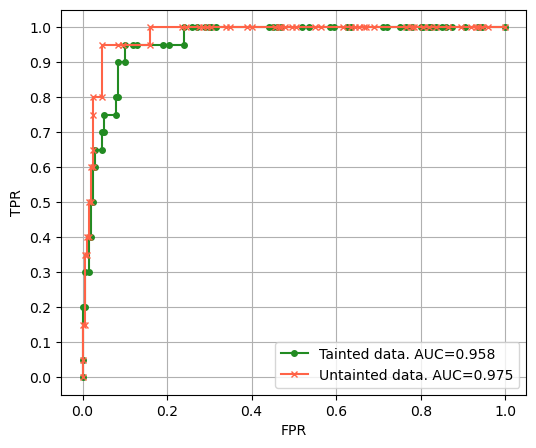

In [52]:
fig, ax = plt.subplots(figsize=[6, 5])
ax.grid()

ax.plot(t_f_fpr, t_f_tpr, linestyle='-', 
            marker='o', color='forestgreen', markersize=4,
            label=f'Tainted data. AUC={"{:.3f}".format(t_f_auc)}')

ax.plot(ut_f_fpr, ut_f_tpr, linestyle='-', 
            marker='x', color='tomato', markersize=4,
            label=f'Untainted data. AUC={"{:.3f}".format(ut_f_auc)}')

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend()
ax.set_yticks(np.arange(0,1.1,0.1))
plt.show()

In [53]:
# max allower false positive rate
MAX_FPR = 0.075

# loop in the false positive ratios, 
# pick the last cut index that yielded less than MAX_FPR
cut_index = 0
for i,rate in enumerate(ut_f_fpr):
  if rate > MAX_FPR:
    cut_index = i-1
    print(f'Threshold chosen yields: TPR={ut_f_tpr[i-1]}, FPR={ut_f_fpr[i-1]}')
    break

threshold = ut_f_thresholds[cut_index]
def detect(datapoint, threshold, forest):
    """
    Returns 1 if the given datapoint is an anomaly, 0 otherwise.
    """
    score = forest.score(datapoint)
    
    if score >= threshold:
      return 1
    return 0 

Threshold chosen yields: TPR=0.95, FPR=0.045


In [54]:
def precision(conf_matrix):
  TP = conf_matrix[0][0]
  FP = conf_matrix[0][1]
  return TP/(TP+FP)

def TPR(conf_matrix):
  TP = conf_matrix[0][0]
  FN = conf_matrix[1][0]
  return TP/(TP+FN)

def FPR(conf_matrix):
  FP = conf_matrix[0][1]
  TN = matrix[1][1]
  return FP/(FP+TN)

In [55]:
matrix = confusion_matrix(testdata_labels, 
                        [detect(datapoint, threshold, untainted_data_forest) 
                        for datapoint in testdata])

In [56]:
print(f'''Results: 
TPR = {"{:.3f}".format(TPR(matrix))}, 
FPR = {"{:.3f}".format(FPR(matrix))}, 
Precision = {"{:.3f}".format(precision(matrix))}''')

Results: 
TPR = 0.995, 
FPR = 0.321, 
Precision = 0.955
